In [1]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')
from ultralytics import YOLO
from glob import glob
from sklearn.metrics import jaccard_score, accuracy_score
import cv2
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

Mounted at /content/drive
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [45]:
# Load trained model
model = YOLO('/content/drive/MyDrive/best (2).pt')

# Path to test images
test_dir = '/content/drive/MyDrive/Binary masks YoloV8/images/test'
image_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))]


0: 256x256 12 teeths, 865.2ms
1: 256x256 19 teeths, 865.2ms
2: 256x256 22 teeths, 865.2ms
3: 256x256 14 teeths, 865.2ms
4: 256x256 13 teeths, 865.2ms


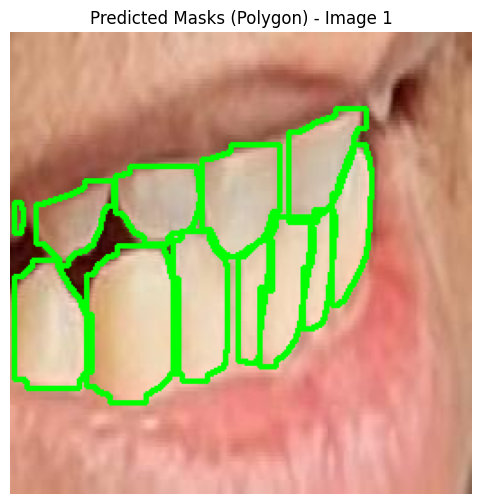

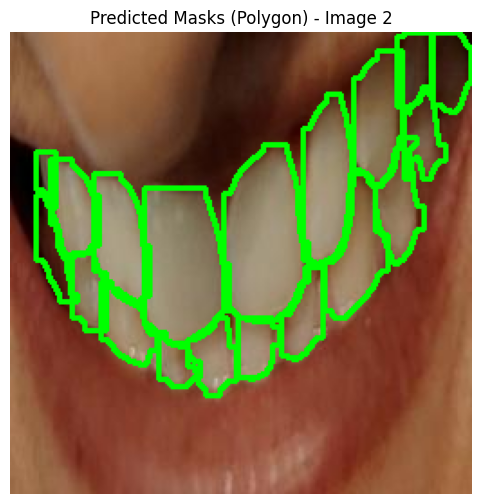

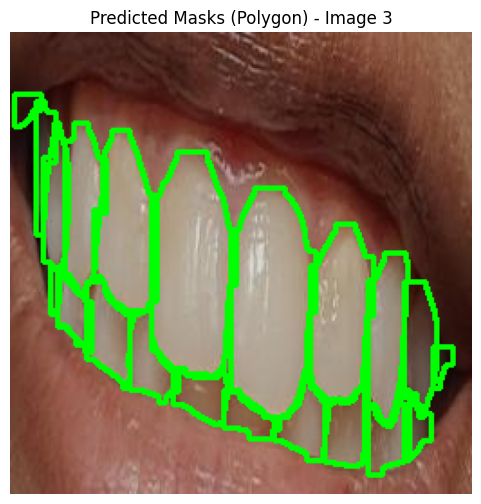

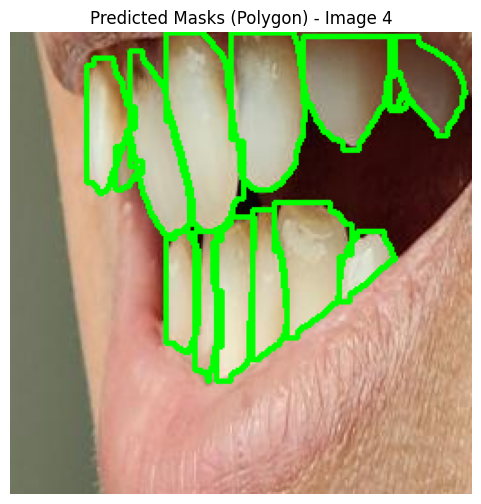

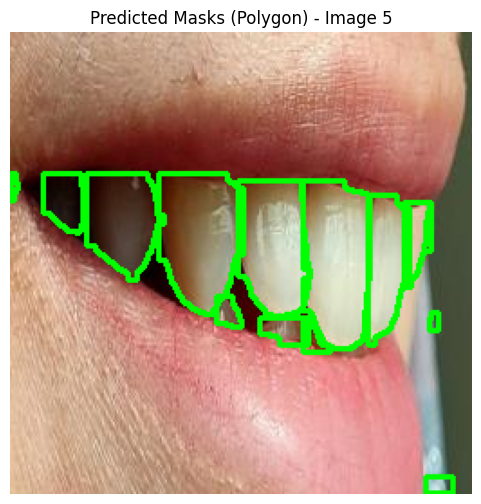

Speed: 0.9ms preprocess, 865.2ms inference, 20.0ms postprocess per image at shape (1, 3, 256, 256)


In [46]:
# Select 5 random image paths
random_images = random.sample(image_files, 5)

# Predict on these random images
results = model.predict(source=random_images, imgsz=256, save=False, stream=True)

# Display results
for i, result in enumerate(results):
    img = result.orig_img.copy()
    masks = result.masks.data.cpu().numpy()  # (N, 256, 256) — binary masks
    boxes = result.boxes.xyxy.cpu().numpy().astype(int)

    # Resize masks to original image shape (if needed)
    img_h, img_w = img.shape[:2]
    seg_img = img.copy()

    for m in masks:
        # Resize mask back to original image size
        m = cv2.resize(m, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
        colored_mask = (m * 255).astype(np.uint8)

        # Find contours (polygons)
        contours, _ = cv2.findContours(colored_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(seg_img, contours, -1, (0, 255, 0), 2)  # Green contours

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Masks (Polygon) - Image {i+1}")
    plt.axis('off')
    plt.show()


In [47]:
# Function to rasterize YOLO segmentation labels into binary mask
def load_yolo_segmentation_mask(label_path, img_shape):
    h, w = img_shape
    mask = np.zeros((h, w), dtype=np.uint8)
    if not os.path.exists(label_path):
        return mask

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            coords = list(map(float, parts[1:]))
            points = np.array(coords).reshape(-1, 2)
            points *= np.array([w, h])
            points = points.astype(np.int32)
            cv2.fillPoly(mask, [points], 1)

    return mask

In [52]:
# Paths
img_dir = '/content/drive/MyDrive/Binary masks YoloV8/images/test'
label_dir = '/content/drive/MyDrive/Binary masks YoloV8/labels/test'

# Load all test image paths
image_files = sorted(glob(os.path.join(img_dir, '*.jpg')))

# Select up to 5 random images
num_images = min(25, len(image_files))
image_files = random.sample(image_files, num_images)

In [49]:
# Predict
results = model.predict(image_files, imgsz=256, save=False, stream=True)

# Loop through results and display
for i, result in enumerate(results):
    image_path = image_files[i]
    label_path = os.path.join(label_dir, os.path.basename(image_path).replace('.jpg', '.txt'))

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Ground truth mask
    gt_mask_bin = load_yolo_segmentation_mask(label_path, (h, w))

    # Predicted mask
    pred_mask_bin = np.zeros((h, w), dtype=np.uint8)
    if result.masks is not None:
        for m in result.masks.data:
            m = m.cpu().numpy()
            m = cv2.resize(m, (w, h), interpolation=cv2.INTER_NEAREST)
            pred_mask_bin = np.logical_or(pred_mask_bin, m > 0.5).astype(np.uint8)

    # Evaluation
    iou = jaccard_score(gt_mask_bin.flatten(), pred_mask_bin.flatten())
    acc = accuracy_score(gt_mask_bin.flatten(), pred_mask_bin.flatten())

    # Create color mask overlays
    green_mask = np.zeros_like(img)
    green_mask[gt_mask_bin == 1] = [0, 255, 0]  # Ground truth in green

    blue_mask = np.zeros_like(img)
    blue_mask[pred_mask_bin == 1] = [0, 0, 255]  # Prediction in blue (BGR to RGB = Blue)

    # Blend masks with original image
    overlay_gt = cv2.addWeighted(img, 1.0, green_mask, 0.4, 0)
    overlay_pred = cv2.addWeighted(img, 1.0, blue_mask, 0.4, 0)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")

    axs[1].imshow(overlay_gt)
    axs[1].set_title("Ground Truth Mask (Green, 50%)")

    axs[2].imshow(overlay_pred)
    axs[2].set_title(f"Predicted Mask (Blue, 50%)\nIoU: {iou:.3f}, Accuracy: {acc:.3f}")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [50]:
ious = []
accuracies = []
# Predict
results = model.predict(image_files, imgsz=256, save=False, stream=True)

# Loop through results and evaluate
for i, result in enumerate(results):
    image_path = image_files[i]
    label_path = os.path.join(label_dir, os.path.basename(image_path).replace('.jpg', '.txt'))

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Ground truth mask
    gt_mask_bin = load_yolo_segmentation_mask(label_path, (h, w))

    # Predicted mask
    pred_mask_bin = np.zeros((h, w), dtype=np.uint8)
    if result.masks is not None:
        for m in result.masks.data:
            m = m.cpu().numpy()
            m = cv2.resize(m, (w, h), interpolation=cv2.INTER_NEAREST)
            pred_mask_bin = np.logical_or(pred_mask_bin, m > 0.5).astype(np.uint8)

    # Evaluation
    iou = jaccard_score(gt_mask_bin.flatten(), pred_mask_bin.flatten())
    acc = accuracy_score(gt_mask_bin.flatten(), pred_mask_bin.flatten())

    ious.append(iou)
    accuracies.append(acc)


0: 256x256 9 teeths, 445.2ms
1: 256x256 15 teeths, 445.2ms
2: 256x256 13 teeths, 445.2ms
3: 256x256 12 teeths, 445.2ms
4: 256x256 9 teeths, 445.2ms
Speed: 0.7ms preprocess, 445.2ms inference, 9.3ms postprocess per image at shape (1, 3, 256, 256)


In [51]:
mean_iou = np.mean(ious)
mean_acc = np.mean(accuracies)

print(f"\nEvaluation Complete\n")
print(f"Mean IoU     : {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f}")


Evaluation Complete

Mean IoU     : 0.9072
Mean Accuracy: 0.9750
